In [1]:
import sys

sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

## Test for boosting from parameter space: Swissmetro

In [95]:
from rumboost.rumboost import rum_train
from rumboost.datasets import load_preprocess_SwissMetro
from rumboost.utility_plotting import plot_parameters
from rumboost.metrics import cross_entropy
import pandas as pd

import lightgbm

In [96]:
# load dataset
swiss_train, swiss_test, folds = load_preprocess_SwissMetro(path="Data/", random_state=3)

In [97]:
def generate_disc_cubic_model(data, feature_names):
    """
    Generate a model based on cubic polynomial features with discontinuities.

    Parameters
    ----------
    data : pd.DataFrame
        The input data.
    feature_names : list
        The names of the features to be used as cubic polynomials in the model.
    """
    new_data = pd.DataFrame({})
    # Generate cubic polynomial features
    for feature in feature_names:
        new_data[f"{feature}_constant"] = data[feature]
        new_data[f"{feature}_linear"] = data[feature]
        new_data[f"{feature}_square"] = data[feature] ** 2
        new_data[f"{feature}_cubic"] = data[feature] ** 3

    return new_data

In [98]:
bin_vars = [
    "MALE",
    "FIRST",
    "PURPOSE_1",
    "PURPOSE_2",
    "PURPOSE_3",
    "PURPOSE_4",
    "AGE_1",
    "AGE_2",
]
cont_vars = [
    "TRAIN_TT",
    "TRAIN_COST",
    "TRAIN_HE",
    "SM_TT",
    "SM_COST",
    "SM_HE",
    "CAR_TT",
    "CAR_CO",
]

X_train = generate_disc_cubic_model(
    swiss_train,
    cont_vars,
)
X_test = generate_disc_cubic_model(
    swiss_test,
    cont_vars,
)
y_train = swiss_train["choice"]
y_test = swiss_test["choice"]
X_train.loc[:, bin_vars] = swiss_train.loc[:, bin_vars].values
X_test.loc[:, bin_vars] = swiss_test.loc[:, bin_vars].values

In [99]:
X_train.head()

,TRAIN_TT_constant,TRAIN_TT_linear,TRAIN_TT_square,TRAIN_TT_cubic,TRAIN_COST_constant,TRAIN_COST_linear,TRAIN_COST_square,TRAIN_COST_cubic,TRAIN_HE_constant,TRAIN_HE_linear,...,CAR_CO_square,CAR_CO_cubic,MALE,FIRST,PURPOSE_1,PURPOSE_2,PURPOSE_3,PURPOSE_4,AGE_1,AGE_2
0,112,112,12544,1404928,48,48,2304,110592,120,120,...,4225,274625,0,0,1,0,0,0,0,0
1,103,103,10609,1092727,48,48,2304,110592,30,30,...,7056,592704,0,0,1,0,0,0,0,0
2,130,130,16900,2197000,48,48,2304,110592,60,60,...,2704,140608,0,0,1,0,0,0,0,0
3,103,103,10609,1092727,40,40,1600,64000,30,30,...,2704,140608,0,0,1,0,0,0,0,0
4,130,130,16900,2197000,36,36,1296,46656,60,60,...,7056,592704,0,0,1,0,0,0,0,0


In [118]:
lr = 0.01
md = 1
verbose = 1
mono = True 
l1 = 0
l2 = 1e-3
min_data_in_leaf = 1
min_sum_hessian_in_leaf = 1e-3
variables_0 = [f for f in X_train.columns if "TRAIN" in f or f in bin_vars]
monotonicity_0 = [0]*len(variables_0)
if mono:
    monotonicity_0 = [-1 if i < 3*4 else 0 for i in range(len(variables_0))] 
dico0 = []
for i, v in enumerate(variables_0):
    dico0.append({
        "utility": [0],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_0[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
        },
        "shared": False,
    })
bfpm0 = [False, True, True, True] * 3 + [False] * len(bin_vars)

variables_1 = [f for f in X_train.columns if "SM" in f or f in bin_vars]
monotonicity_1 = [0]*len(variables_1)
if mono:
    monotonicity_1 = [-1 if i < 3*4 else 0 for i in range(len(variables_1))]
dico1 = []
for i, v in enumerate(variables_1):
    dico1.append({
        "utility": [1],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_1[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
        },
        "shared": False,
    })
bfpm1 = [False, True, True, True] * 3 + [False] * len(bin_vars)
    
variables_2 = [f for f in X_train.columns if "CAR" in f or f in bin_vars]
monotonicity_2 = [0]*len(variables_2)
if mono:
    monotonicity_2 = [-1 if i < 2*4 else 0 for i in range(len(variables_2))]
dico2 = []
for i, v in enumerate(variables_2):
    dico2.append({
        "utility": [2],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_2[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
        },
        "shared": False,
    })
bfpm2 = [False, True, True, True] * 2 + [False] * len(bin_vars)

rum_structure = dico0 + dico1 + dico2
boost_from_param_space = bfpm0 + bfpm1 + bfpm2

In [119]:
# parameters
general_params = {
    "n_jobs": -1,
    "num_classes": 3,  # important
    "verbosity": 1,  # specific RUMBoost parameter
    "num_iterations": 2000,
    "early_stopping_round": 10,
    "max_booster_to_update": 16*3,
    "boost_from_parameter_space": boost_from_param_space,
    "verbose_interval": 1,
    "params_monotonic_function": "relu",
    "optim_interval": 1,
}

In [120]:
torch_tensors = {"device":"cuda"}
# torch_tensors = None

In [121]:
model_specification = {
    "general_params": general_params,
    "rum_structure": rum_structure,
}

In [122]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [123]:
scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
# create lightgbm dataset
lgb_train_set = lightgbm.Dataset(
    X_train_scaled, label=y_train, free_raw_data=False
)
lgb_test_set = lightgbm.Dataset(
    X_test_scaled, label=y_test, free_raw_data=False
)

In [124]:
import copy
num_trees = 0
folds_cp = copy.deepcopy(folds)
for train_idx, val_idx in folds_cp:
    lgb_train_cv_set = lightgbm.Dataset(
        X_train_scaled.iloc[train_idx], label=y_train.iloc[train_idx], free_raw_data=False
    )
    lgb_val_set = lightgbm.Dataset(
        X_train_scaled.iloc[val_idx], label=y_train.iloc[val_idx], free_raw_data=False
    )
    
    model_cv = rum_train(lgb_train_cv_set, model_specification, valid_sets=[lgb_val_set], torch_tensors=torch_tensors)
    num_trees += model_cv.best_iteration

/home/nicolas-salvade/rumboost-dev/rumboost/rumboost.py:2656: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Using torch tensors on cuda
[LightGBM] [Warning] Unknown parameter: params_monotonic_function
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval
[LightGBM] [Warning] Unknown parameter: params_monotonic_function
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 3788, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead o

/home/nicolas-salvade/rumboost-dev/rumboost/rumboost.py:2656: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective f

/home/nicolas-salvade/rumboost-dev/rumboost/rumboost.py:2656: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 3789, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 3789, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 3789, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of test

/home/nicolas-salvade/rumboost-dev/rumboost/rumboost.py:2656: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Using torch tensors on cuda
[LightGBM] [Warning] Unknown parameter: params_monotonic_function
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval
[LightGBM] [Warning] Unknown parameter: params_monotonic_function
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 243
[LightGBM] [Info] Number of data points in the train set: 3791, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead o

/home/nicolas-salvade/rumboost-dev/rumboost/rumboost.py:2656: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Using torch tensors on cuda
[LightGBM] [Warning] Unknown parameter: params_monotonic_function
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval
[LightGBM] [Warning] Unknown parameter: params_monotonic_function
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 3791, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead o

In [125]:
print(num_trees / 5)
model_specification["general_params"]["num_iterations"] = int(num_trees / 5)
model_specification["general_params"]["early_stopping_round"] = None



174.8


In [126]:
LPMC_model_fully_trained = rum_train(lgb_train_set, model_specification, torch_tensors=torch_tensors, valid_sets=[lgb_test_set])

/home/nicolas-salvade/rumboost-dev/rumboost/rumboost.py:2656: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Using torch tensors on cuda
[LightGBM] [Warning] Unknown parameter: params_monotonic_function
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval
[LightGBM] [Warning] Unknown parameter: params_monotonic_function
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 6318, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead o

In [127]:
preds = LPMC_model_fully_trained.predict(lgb_test_set).cpu().numpy()

print(cross_entropy(preds, y_test.values))

0.7844566444868325


/tmp/ipykernel_815850/2627697236.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


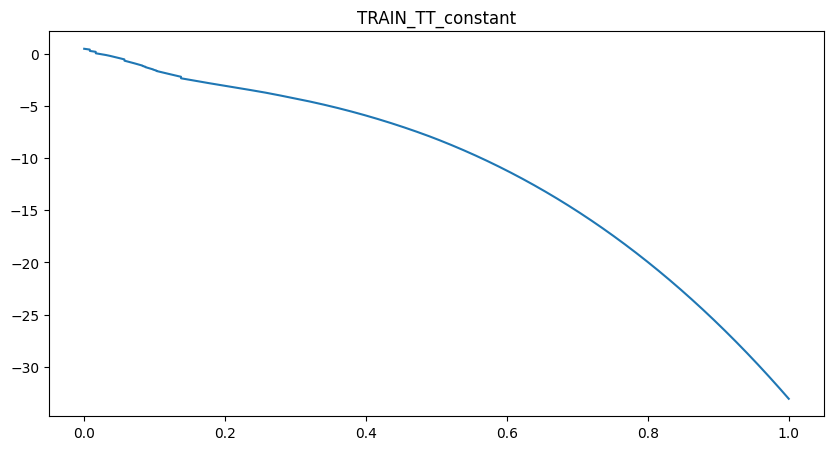

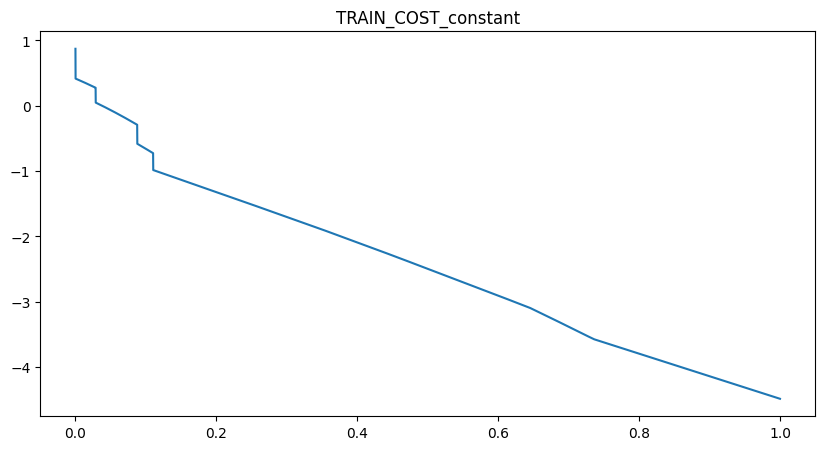

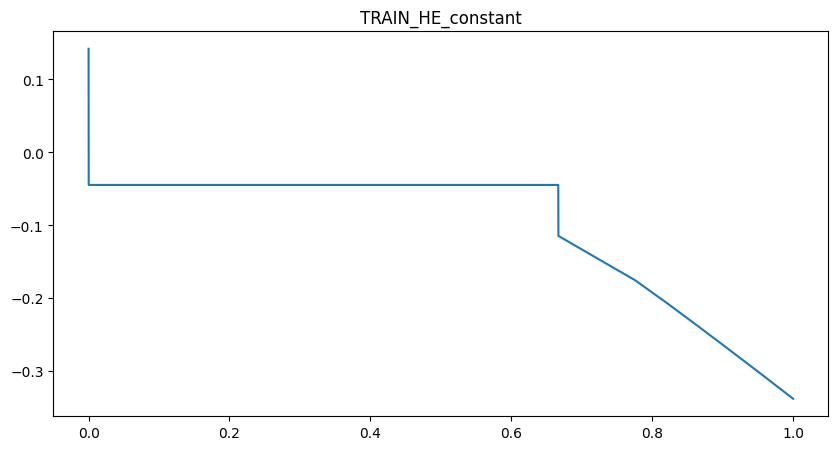

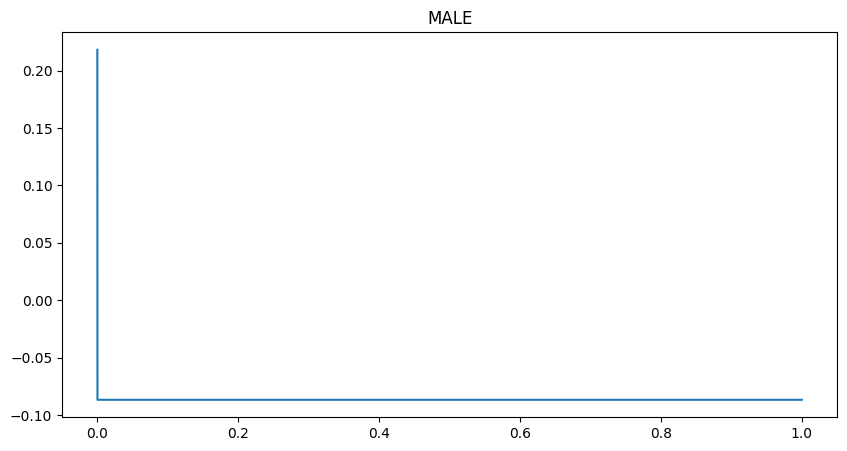

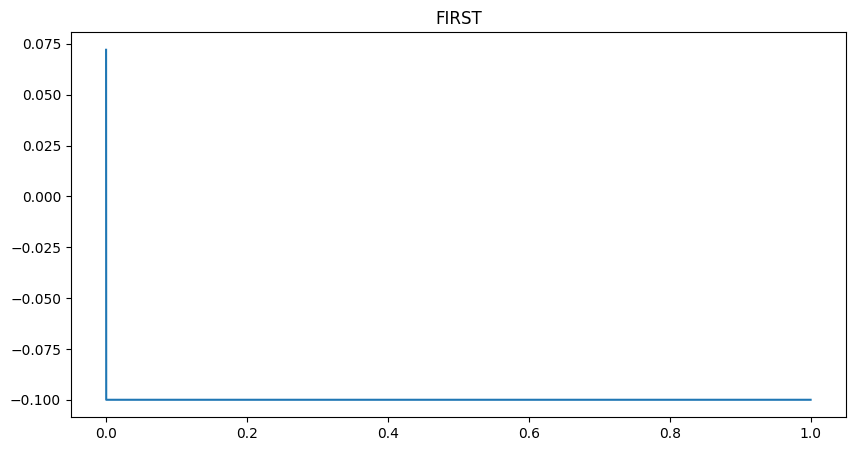

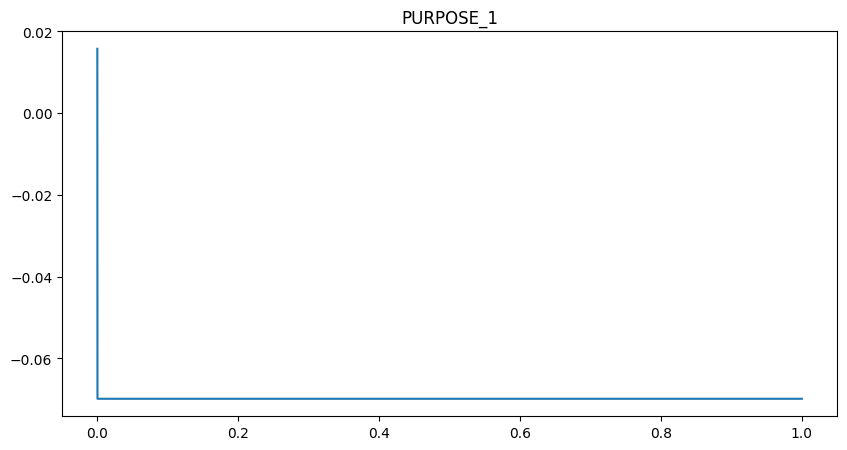

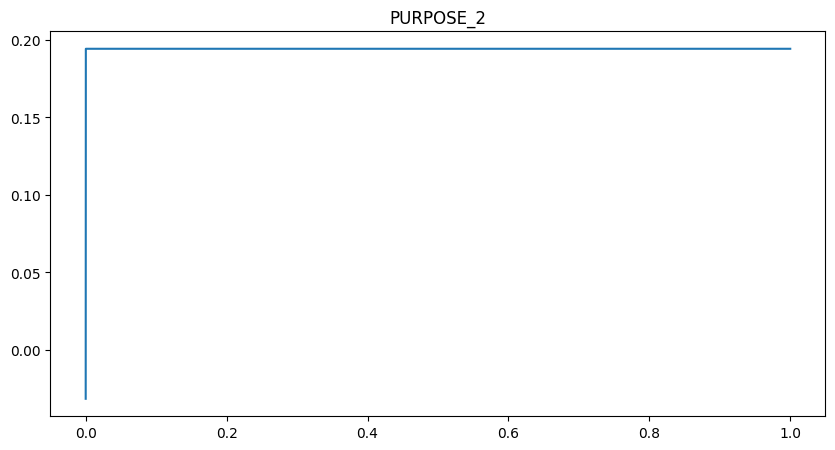

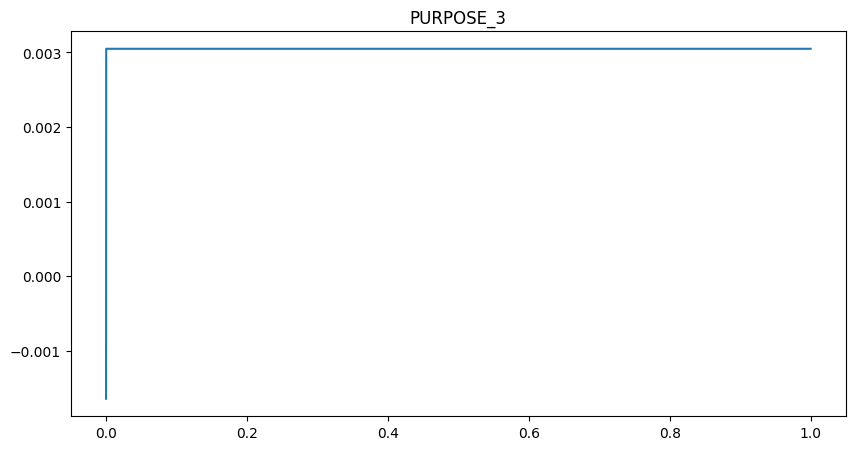

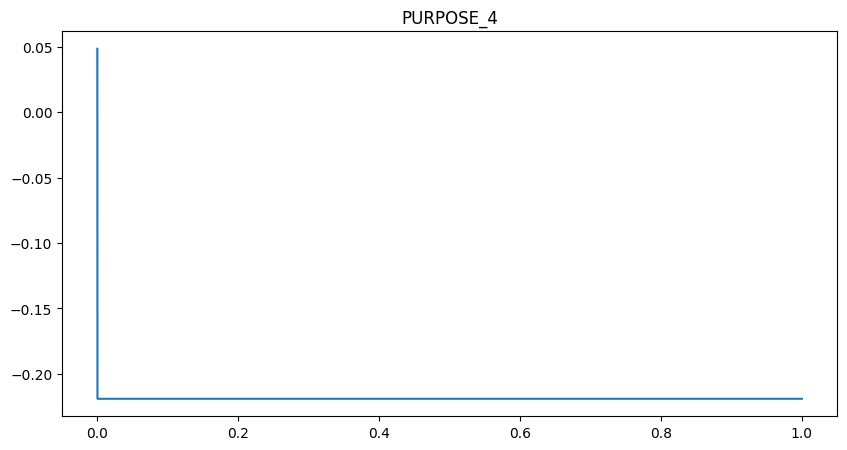

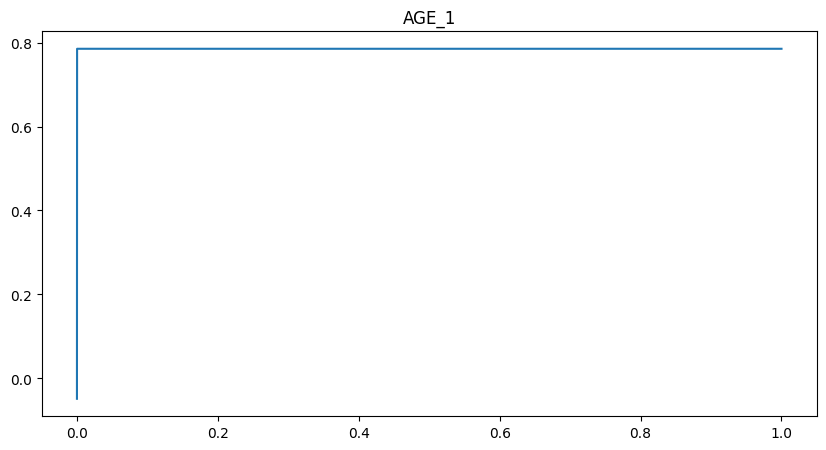

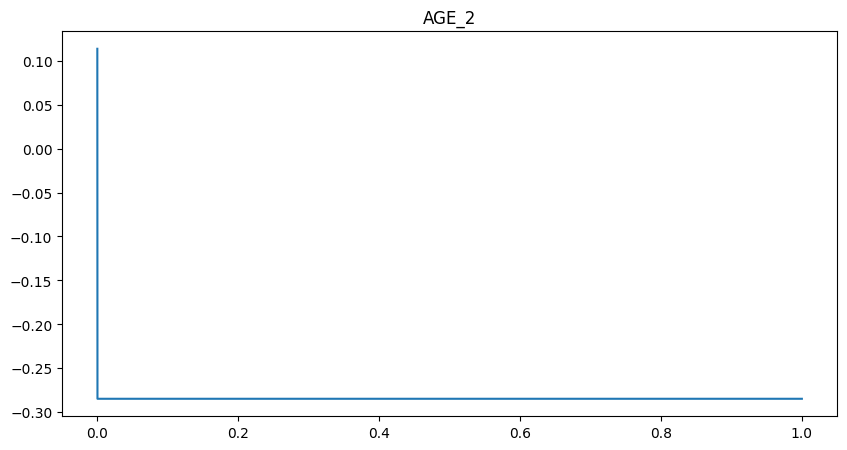

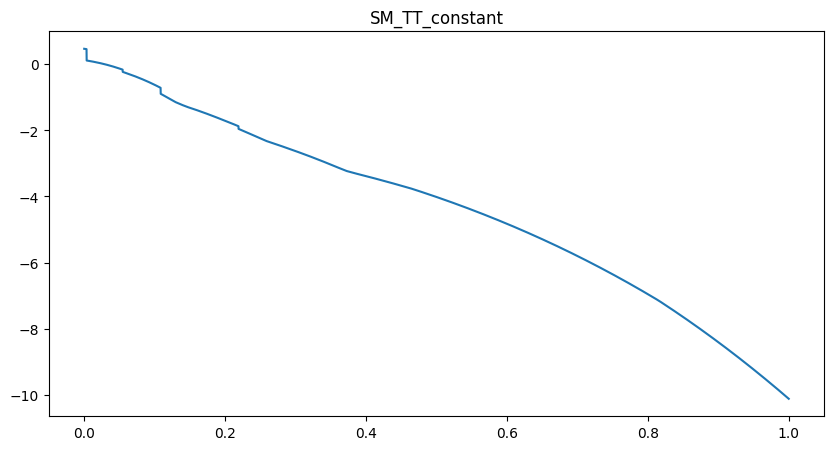

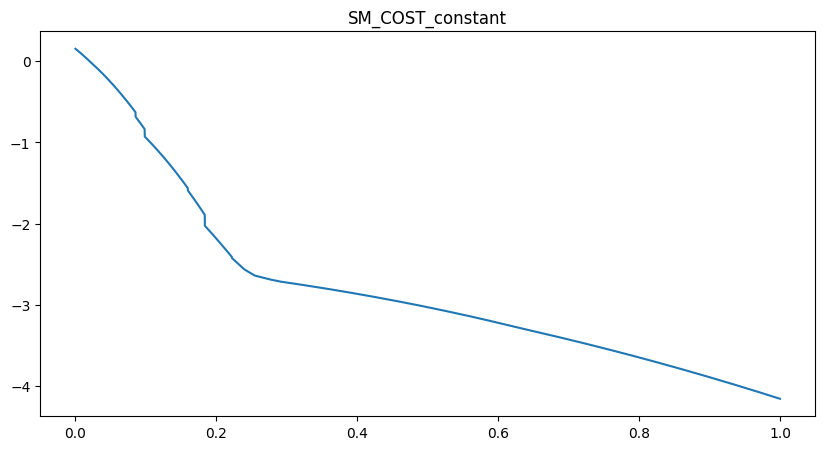

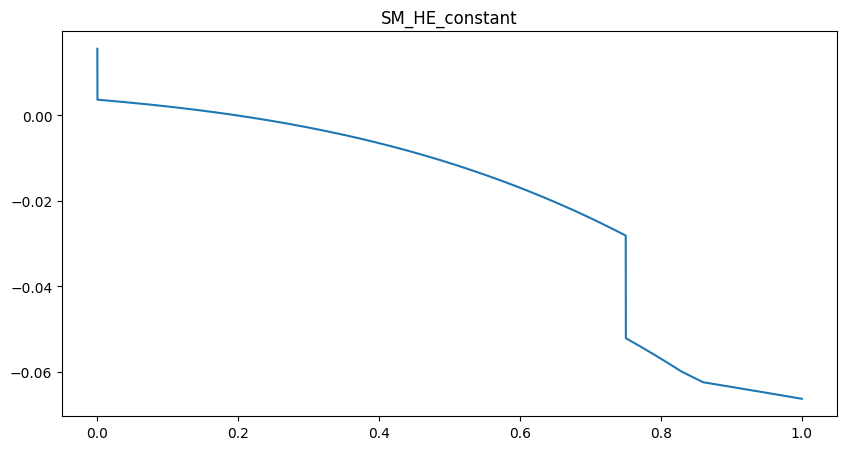

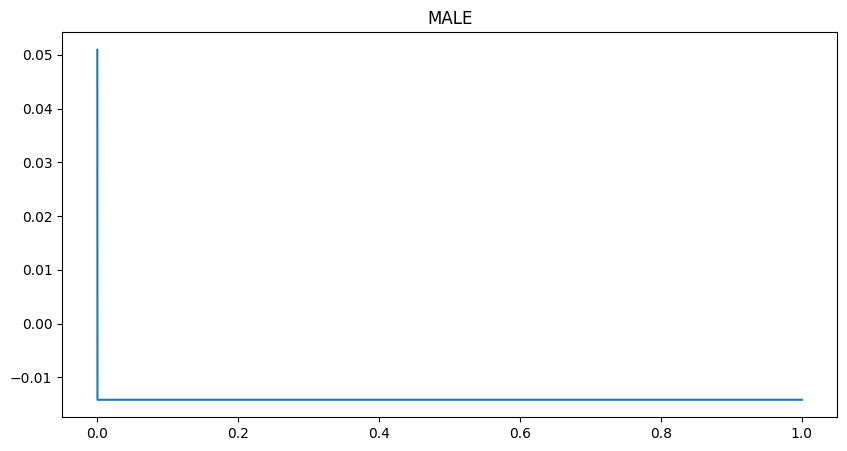

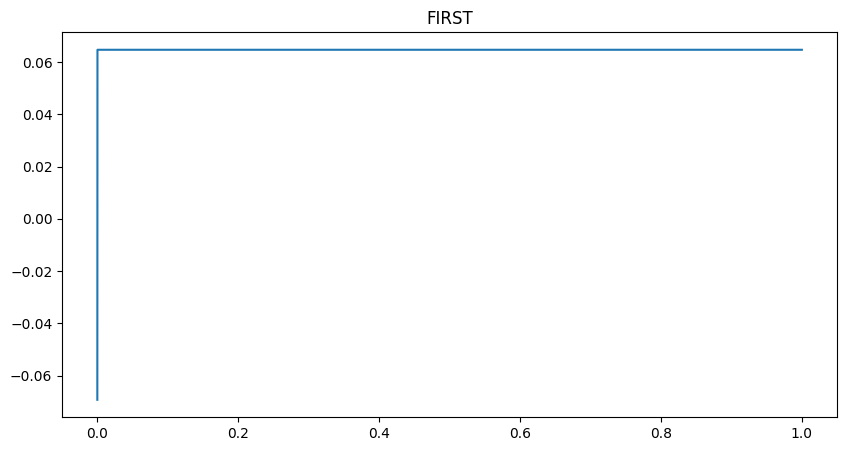

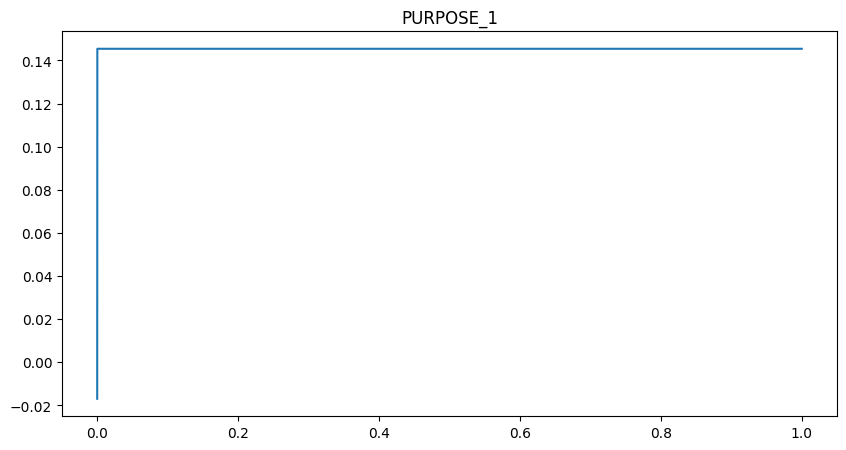

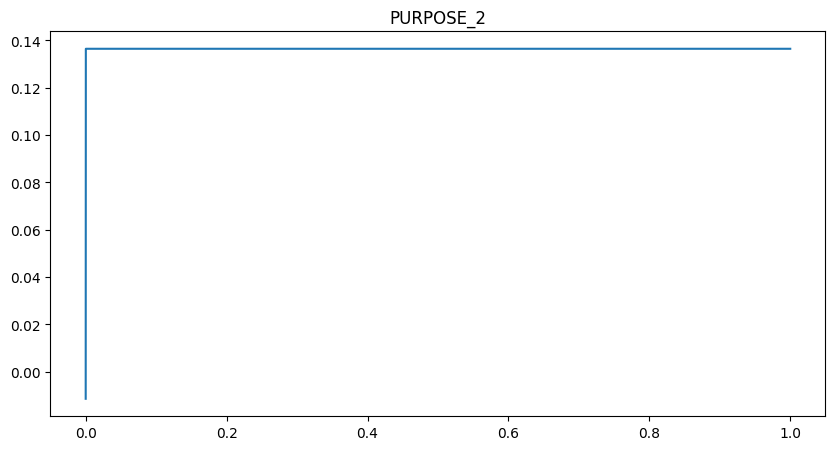

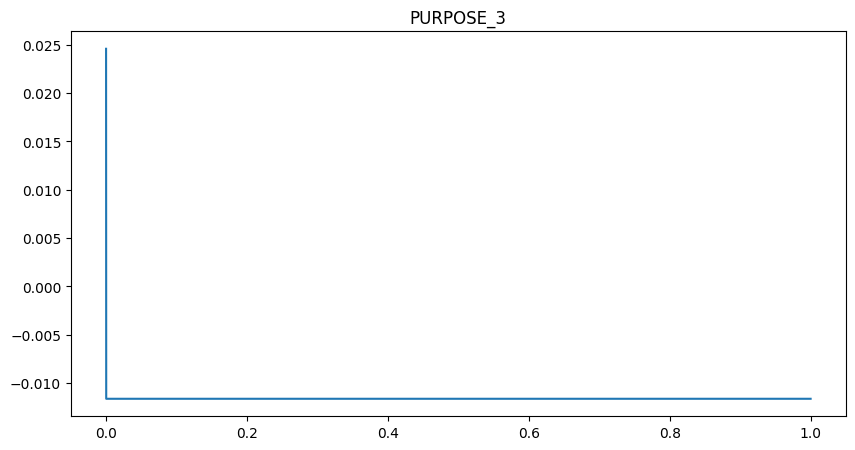

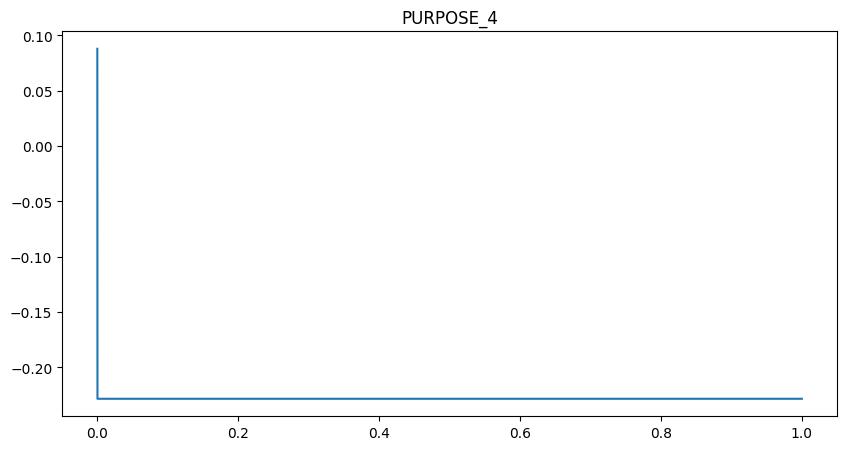

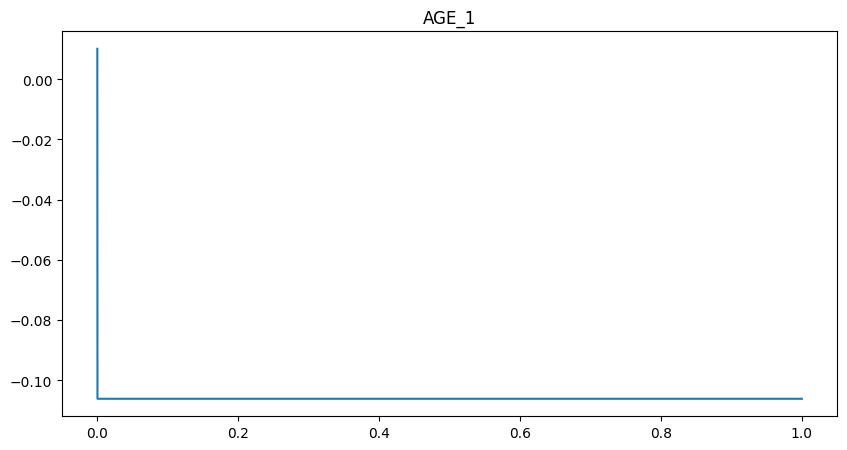

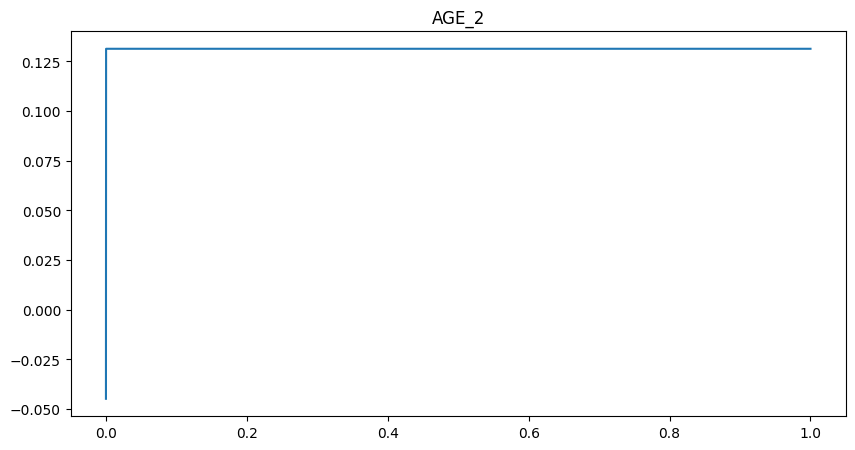

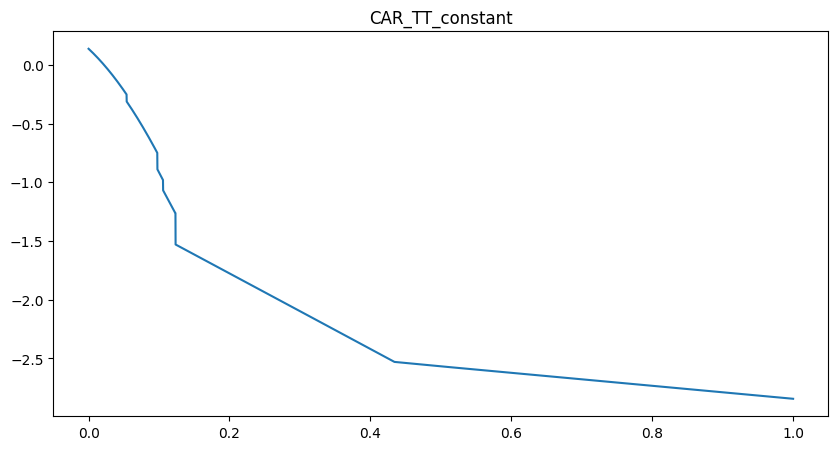

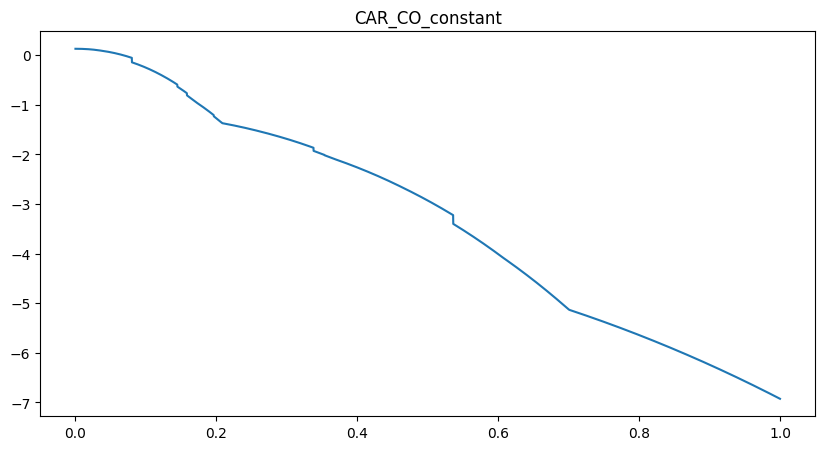

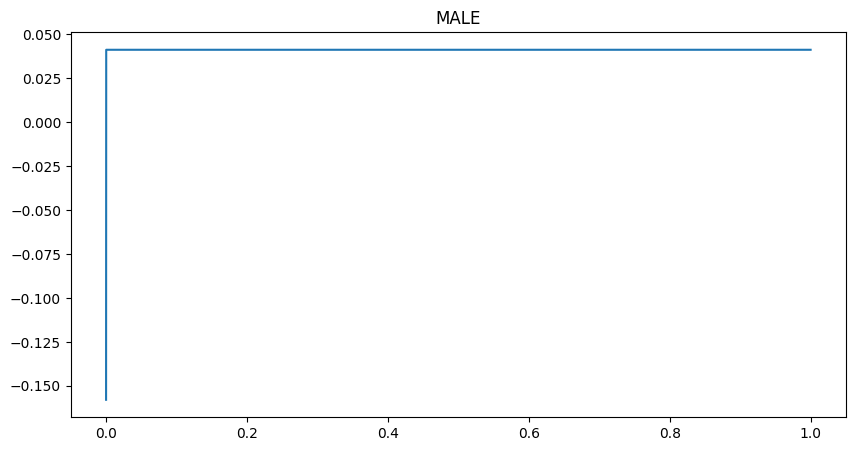

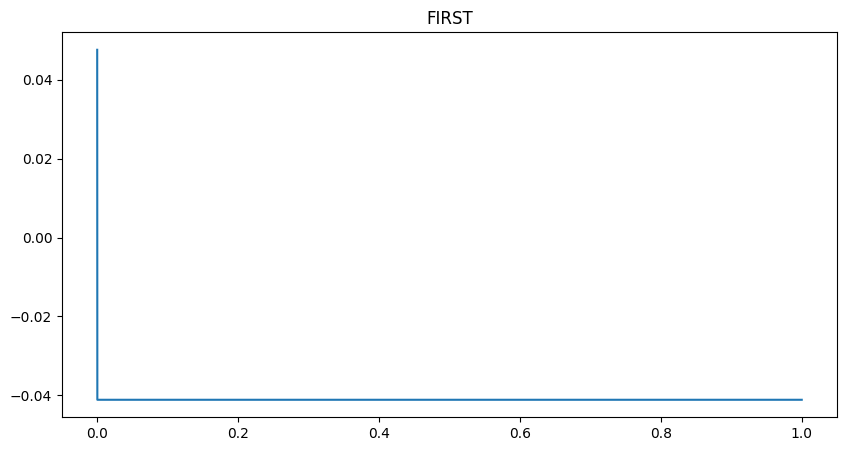

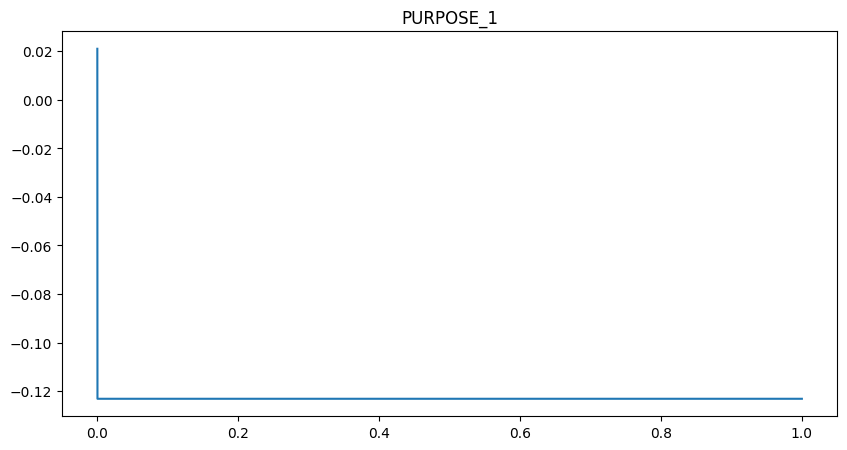

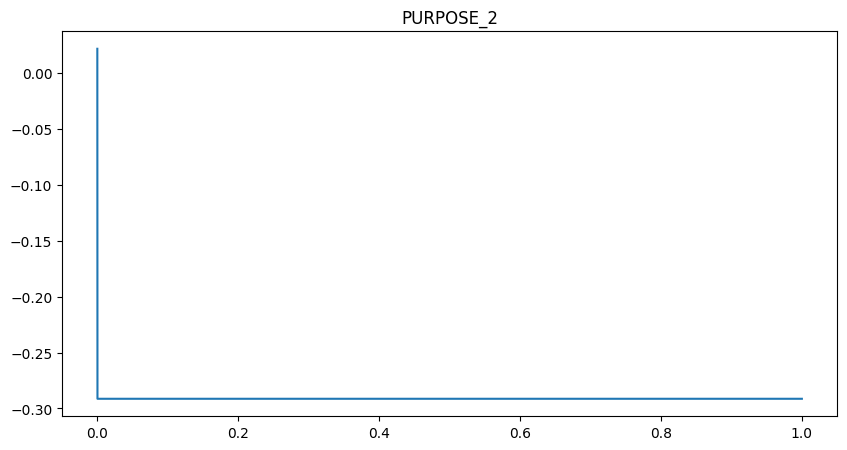

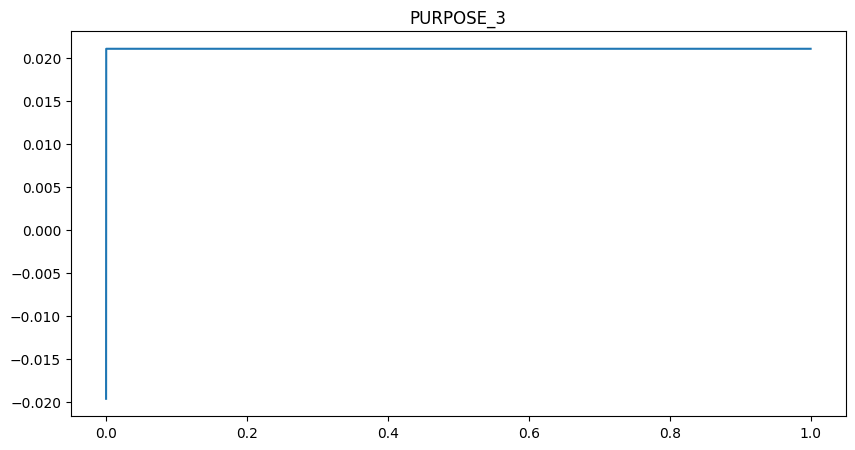

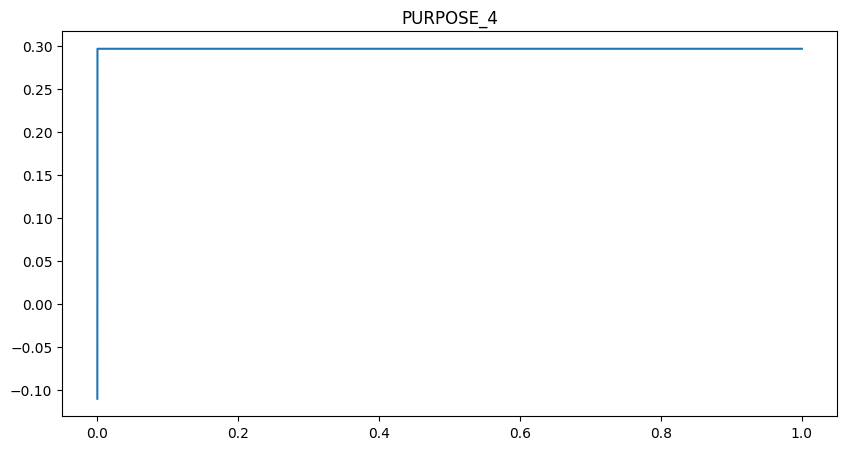

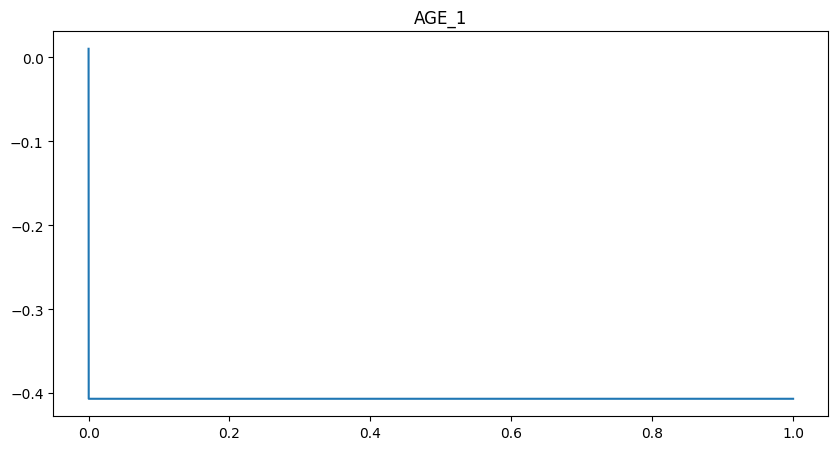

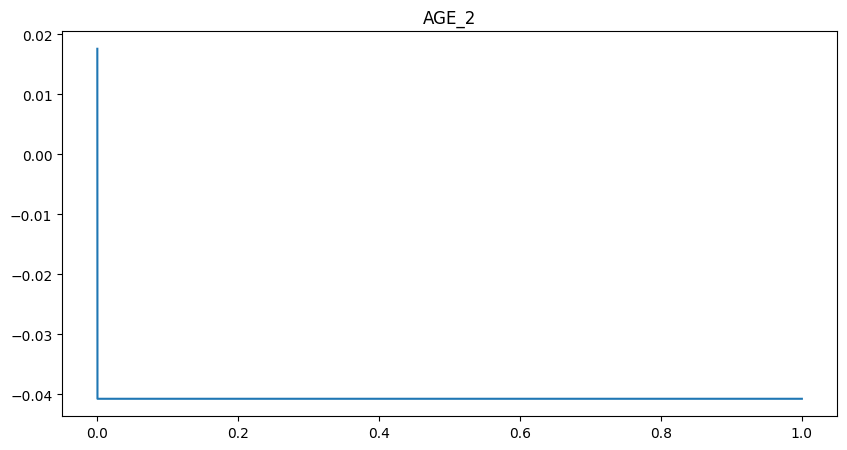

In [138]:
import numpy as np
import matplotlib.pyplot as plt
fake_data = np.linspace(0, 1, 10000)

preds = np.array([booster.predict(fake_data.reshape(-1,1)) for booster in LPMC_model_fully_trained.boosters])

num_plots = 3 + 3 + 2 + len(bin_vars)*3

k = 0
for i in range(num_plots):
    if "TRAIN" in rum_structure[k]["variables"][0] or "SM" in rum_structure[k]["variables"][0] or "CAR" in rum_structure[k]["variables"][0]:
        preds0 = LPMC_model_fully_trained.boosters[k].predict(fake_data.reshape(-1,1))
        preds1 = LPMC_model_fully_trained._linear_predict(k + 1, fake_data.reshape(-1,1)).squeeze().cpu().numpy()
        preds2 = LPMC_model_fully_trained._linear_predict(k + 2, fake_data.reshape(-1,1)**2).squeeze().cpu().numpy()
        preds3 = LPMC_model_fully_trained._linear_predict(k + 3, fake_data.reshape(-1,1)**3).squeeze().cpu().numpy()
        preds_plot = preds0 + preds1 + preds2 + preds3
        f_name = rum_structure[k]["variables"][0]
        k += 4
    else:
        preds_plot = LPMC_model_fully_trained.boosters[k].predict(fake_data.reshape(-1,1))
        f_name = rum_structure[k]["variables"][0]
        k += 1
    plt.figure(figsize=(10, 5))
    plt.plot(fake_data, preds_plot)
    plt.title(f"{f_name}")